In [1]:
#import warnings
#warnings.filterwarnings("ignore")
from __future__ import print_function, division
%matplotlib inline
import time
import tqdm
from tqdm import tqdm_notebook as tqdm_notebook
from tqdm import trange
import logging
from collections import OrderedDict
logger = logging.getLogger(__name__)

# Your code goes here
import os
import subprocess
from pathlib import Path
import numpy as np
from numpy import testing
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import seaborn as sns

from sklearn.metrics import adjusted_rand_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, Normalizer

import metric_learn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import DistanceMetric
from sklearn.neighbors.ball_tree import BallTree
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

# Shogun - Metric Learning
from shogun import LMNN as shogun_LMNN
from shogun import RealFeatures, MulticlassLabels
from sklearn.utils.validation import check_X_y, check_array


# POT imports
import ot
from ot.datasets import get_1D_gauss as gauss

# MML import 
from mml import wasserstein, transform, gml, ot_testing, datasets, helper

data_path = str(Path(os.getcwd())) + "/data/"
multiclass_path = str(Path(os.getcwd())) + "/results/multiclass/"
binary_path = str(Path(os.getcwd())) + "/results/binary/"
knn_data = str(Path(os.getcwd())) + "/data/knn_data/"

def write_to_pickle(dataframe, name):
    dataframe.to_pickle(data_path + name + ".pickle")
def read_from_pickle(name): 
    return pd.read_pickle(data_path + name + ".pickle")

In [2]:
from sklearn.decomposition import PCA

In [3]:
import importlib
importlib.reload(wasserstein)
importlib.reload(gml)
importlib.reload(helper)

<module 'mml.helper' from '/Users/patricfulop/Documents/Code/Optimal/mml/helper.py'>

In [4]:
# Load Hellinger representation of the data 
#X,Y = datasets.load_mnist("Hellinger")
X= np.load(data_path+"X.npy")
Y= np.load(data_path+"Y.npy")

In [5]:
X.shape

(1797, 64)

In [6]:
X_train_normalized = np.load(knn_data+ "X_train_normalized.npy")
X_test_normalized = np.load(knn_data+ "X_test_normalized.npy")
Y_train = np.load(knn_data+ "Y_train.npy")

In [7]:
Y_train.shape

(449,)

In [42]:
# Transform the data using 95% of variance. 
X_train_std = StandardScaler().fit_transform(X)

In [47]:
X_train_std[5].var()

0.74832578187866983

In [29]:
X_train_normalized[6].shape

(64,)

## Fit PCA on normalized reduced dataset, with test dataset bigger

In [8]:
# Has to be square number
pca = PCA(n_components=36)
pca.fit(X_train_normalized)
X_train_pca = pca.transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)

In [50]:
helper.save_ndarray(data_path+"PCA_Components",pca.components_)

In [38]:
helper.save_ndarray(data_path+"X_train_pca",X_train_pca)
helper.save_ndarray(data_path+ "X_test_pca",X_test_pca)

## Fit PCA on original dataset, with test dataset smaller

In [13]:
pca1 = PCA(n_components=36)
pca1.fit(X)
X_PCA = pca1.transform(X)

In [25]:
# I'm pretty sure X_PCA was generated using the above
helper.save_ndarray(data_path+"X_PCA",X_PCA)

In [18]:
X_train, X_test,Y_train,Y_test = train_test_split(X_PCA,Y,train_size=0.25,test_size=0.75,random_state=123)

In [20]:
d = X_train.shape[1]
x = np.arange(d,dtype=np.float64)
x2 = x.reshape((d,1))
M_sqeuclidean = ot.dist(x2,x2,metric='sqeuclidean')
M_eye = ot.dist(x2,x2,metric='hamming')

xx,yy = np.meshgrid(np.arange(np.sqrt(d)),np.arange(np.sqrt(d)))
xy = np.hstack((xx.reshape(-1,1),yy.reshape(-1,1)))
M_mesh = ot.dist(xy, xy)
M = M_mesh

In [22]:
d 

38

In [ ]:
X_latent = np.load(data_path + "latent/X_train_mu.npy")
Y_latent = np.load(data_path + "latent/Y_train.npy")

In [ ]:
(X < 0).sum()

In [ ]:
X_latent.shape

In [ ]:
# Representation so far is a matrix of row vectors each representing a digit..
# Let's make it the same way for Caltech - do you think it will hold in memory? 

In [ ]:
data_dict = datasets.mnist_dictionary(X,Y)

# This method also need to make sure you're choosing a balanced dataset, with n digits from each bin
# This method does not exist yet
# [x12,y12] = datasets.data_pairs(data_dict,1,2,no_samples = 30)
[x12,y12] = datasets.data_pairs(data_dict,1,2)

X_train,X_test,Y_train,Y_test = train_test_split(x12,y12,train_size=0.25,test_size=0.75,random_state=123)

X_train_normalized = X_train/X_train.sum(axis=1).reshape((-1,1))
X_test_normalized = X_test/X_test.sum(axis=1).reshape((-1,1))
n = X_train_normalized.shape[0]    

## Print learned distances and objective functions - can I get the objective to act more nicely?

## Binary experiments 
- Print at least 5 experiments with different digits and their objective on the same plot
- Print for the Caltech dataset as well

## Multiclass experiments 
- Print 1 run of experiment 

In [26]:
gml_pca = np.load(multiclass_path + "gml_mnist_sift_pca.npy")
obj_pca = helper.load_json(multiclass_path+"objective_mnist_sift_pca")

In [44]:
gml_pca1 = np.load(multiclass_path +"gml_mnist_sift_pca_1.npy")
obj_pca1 = helper.load_json(multiclass_path +"objective_mnist_sift_pca_1")

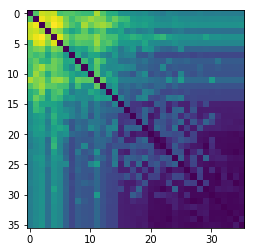

In [46]:
plt.imshow(gml_pca1);

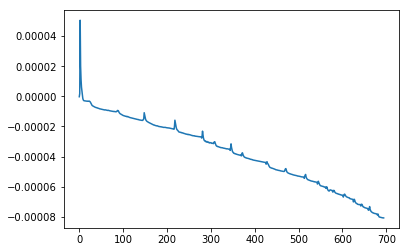

In [48]:
plt.plot(obj_pca1);

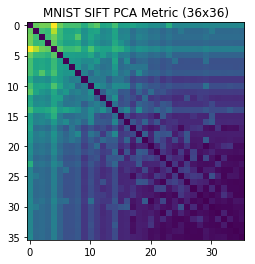

In [27]:
plt.title("MNIST SIFT PCA Metric (36x36)")
plt.imshow(gml_pca);
plt.savefig("MNIST_SIFT_PCA")

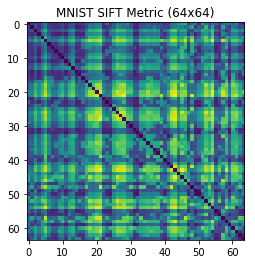

In [31]:
M_gml_sift = np.load(multiclass_path + "gml_mnist_sift.npy")
plt.title("MNIST SIFT Metric (64x64)")
plt.imshow(M_gml_sift)
plt.savefig("MNIST_SIFT")

In [32]:
#gml_multi = np.load(multiclass_path + "gml_mnist.npy")
obj_multi = helper.load_json(multiclass_path+"objective_mnist_sift")

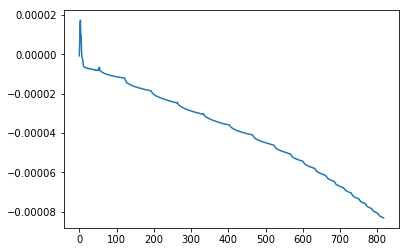

In [33]:
plt.plot(obj_multi)

In [ ]:
gml_original = np.load(multiclass_path+"gml30samples.npy")

In [ ]:
gml59 = np.load(binary_path+"matrix17.npy")
obj59 = helper.load_json(binary_path+"objective17")

In [ ]:
plt.title("MNIST SIFT Metric (64x64)")
plt.imshow(gml_original);
plt.savefig("MNIST_SIFT")

In [ ]:
plt.title("MNIST VAE Metric (25x25)")
plt.imshow(gml_multi);
plt.savefig("MNIST_VAE")

In [ ]:
plt.plot(obj59);